In [4]:

!pip install helical --use-pep517

!pip install datasets --upgrade

  Using cached helical-0.0.1a16-py3-none-any.whl.metadata (51 kB)
  Using cached accelerate-0.29.3-py3-none-any.whl.metadata (18 kB)
  Using cached anndata-0.10.7-py3-none-any.whl.metadata (6.6 kB)
  Using cached azure_core-1.30.1-py3-none-any.whl.metadata (37 kB)
  Using cached azure_identity-1.16.0-py3-none-any.whl.metadata (76 kB)
  Using cached azure_storage_blob-12.19.1-py3-none-any.whl.metadata (26 kB)
  Using cached datasets-2.20.0-py3-none-any.whl.metadata (19 kB)
  Using cached einops-0.8.0-py3-none-any.whl.metadata (12 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl.metadata (13 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached loompy-3.0.7-py3-none-any.whl
  Using cached louvain-0.8.2.tar.gz (4.2 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend d

  error: subprocess-exited-with-error
  
  × Building wheel for louvain (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [27 lines of output]
      C:\Users\tomjo\AppData\Local\Temp\pip-build-env-pqwnljq2\overlay\Lib\site-packages\setuptools\_distutils\dist.py:261: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      WARNING setuptools_scm.pyproject_reading toml section missing 'pyproject.toml does not contain a tool.setuptools_scm section'
      Traceback (most recent call last):
        File "C:\Users\tomjo\AppData\Local\Temp\pip-build-env-pqwnljq2\normal\Lib\site-packages\setuptools_scm\_integration\pyproject_reading.py", line 36, in read_pyproject
          section = defn.get("tool", {})[tool_name]
                    ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
      KeyError: 'setuptools_scm'
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-312\louvain
      copying src\louvain\f

In [2]:

from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import anndata as ad
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from scipy.sparse import lil_matrix
import torch.optim as optim
from helical.models.scgpt.model import scGPT, scGPTConfig
from helical.models.geneformer.model import Geneformer, GeneformerConfig
from copy import deepcopy
from torch.nn.functional import one_hot
import torch
print(torch.__version__)  # Should print a version like 2.0.1+cu118 or 2.1.0+cu121
print(torch.version.cuda)  # Should print the CUDA version (e.g., 11.8 or 12.1)
print(torch.cuda.is_available()) 

INFO:datasets:PyTorch version 2.5.1+cu118 available.
INFO:helical:Caduceus not available: If you want to use this model, ensure you have a CUDA GPU and have installed the optional helical[mamba-ssm] dependencies.


2.5.1+cu118
11.8
True


In [3]:
from datasets import load_dataset
ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, split="train[:65%]",download_mode="reuse_cache_if_exists")

Generating test split: 100%|██████████| 6336/6336 [00:03<00:00, 1717.12 examples/s]


In [4]:
observation_columns = [obs for obs in list(ds.features.keys()) if not obs == 'raw_counts']
obs_data = pd.DataFrame(ds.select_columns(observation_columns).data.to_pandas(),columns=observation_columns)
lil = lil_matrix((len(ds),ds[0]['size']))
lil.data = np.array(ds['raw_counts'],dtype="object")
lil.rows = np.array(ds['rows'],dtype="object")
adata = ad.AnnData(lil.tocsr(),obs=obs_data)
adata.var_names = ds.features['raw_counts'].id.split(",")
adata.var['gene_name'] = adata.var_names.str.upper()

In [5]:
# get labels: the celltype
num_types = adata.obs["LVL1"].unique().shape[0]
id2type = dict(enumerate(adata.obs["LVL1"].astype("category").cat.categories))

celltypes_labels = np.array(adata.obs["LVL1"].tolist())

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
scgpt_config = scGPTConfig(batch_size=50, device=device)
scgpt = scGPT(configurer = scgpt_config)
#print(load_model(scgpt_config)[1])


def knockout_genes(data,model,genes):
  """ Generate embeddings for the original dataset and modified dataset using
  the selected model. The modified dataset has gene expressions set to 0 for
  all genes present in the genes list.

  Inputs:
      data (anndata): dataset that is being considered
      model ()
  """
  # knockout genes using batching to reduce explosion in RAM usage
  batch_size = 100
  original_data = data.copy()
  #print(len(genes))
  
  gene_indices = [data.var.index.get_loc(gene) for gene in genes if gene in data.var.index]
  # update data in a vectorised way all at once to reduce memory spike
  data.X[:,gene_indices] = 0 
  
  new_data = model.process_data(adata = data, gene_names="gene_name")
  print([i for i in range(100) if data.var["gene_name"][i] not in new_data.vocab])
  
  
  x_model_dropped = model.get_embeddings(new_data)
  # generate embeddings on original data
  new_data1 = model.process_data(adata = original_data, gene_names = "gene_name")
  x_model = model.get_embeddings(new_data1)
  return x_model, x_model_dropped
#genes_to_knockout = ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M']
genes_to_knockout = list(adata.var_names[0:40])

x_modelt, x_model_droppedt = knockout_genes(adata,scgpt,genes_to_knockout)


INFO:helical.utils.downloader:File: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/vocab.json' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/vocab.json'
INFO:helical.utils.downloader:File: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/best_model.pt' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/best_model.pt'
INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:


[15, 23, 33, 34, 39, 82]


Embedding cells: 100%|██████████| 330/330 [03:22<00:00,  1.63it/s]
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:
Embedding cells: 100%|██████████| 330/330 [03:29<00:00,  1.58it/s]


In [7]:
#axis=0 gives largest embedding, axis=1 gives example with largest impact
print(np.argmax(np.sum(x_modelt,0)))
print(np.argmax(np.sum(x_modelt,1)))
print(np.argmax(np.sum(x_model_droppedt,0)))
print(np.argmax(np.sum(x_model_droppedt,1)))
print(np.argmin(np.sum(x_modelt,0)))
print(np.argmin(np.sum(x_modelt,1)))
print(np.argmin(np.sum(x_model_droppedt,0)))
print(np.argmin(np.sum(x_model_droppedt,1)))

260
9950
260
9950
157
12522
157
12522


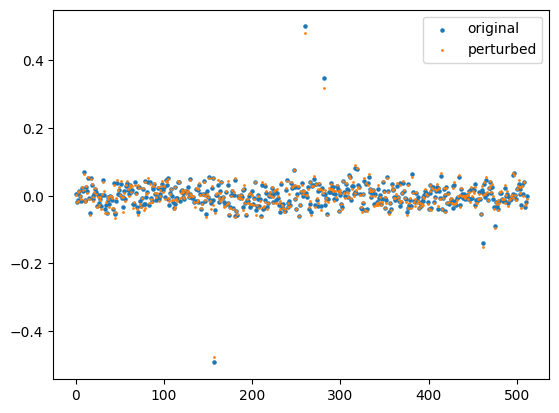

[False False False False False False False False False False]


In [10]:
import matplotlib.pyplot as plt
i=200
plt.figure()
plt.scatter(list(range(len(x_modelt[16,:]))), x_modelt[16,:], label="original",s=5)
plt.scatter( list(range(len(x_modelt[16,:]))), x_model_droppedt[16,:], label="perturbed",s=1)
plt.legend()
plt.show()
print(x_modelt[0:10,i]==x_model_droppedt[0:10,i])

By looking at how the first gene impacts all of the embeddings, we can see that when the gene is knocked out the embeddings with magnitude greater than 0.2 are decreased by a small amount. Showing that the embedding is less dependent on the information provided by this one gene (no information in this case). However, smaller embeddings are perturbed in a more stochastic looking manner. With some increasing and some decreasing.

In [11]:

# for all embeddings find the MSE between orginal and unperturbed data
#for i in range(len(x_model[0])):
mse = 0
for i,j in zip(x_modelt,x_model_droppedt):
  mse += (i-j)**2
# find which embedding depends the most on the genes that have been knocked out
print(np.argmax(mse))
mse = 0
for i,j in zip(x_modelt.T,x_model_droppedt.T):
  mse += (i-j)**2
# find which genes now has been reduced in importance by the largest amount
print(np.argmax(mse))


281
237


In [50]:
#genes_to_knockout = list(adata.var_names[0:int(len(adata.var_names)/10)])
x_model10, x_model_dropped10 = 0,0
#genes_to_knockout = list(adata.var_names[0:int(len(adata.var_names)/5)])
x_model20, x_model_dropped20 = 0,0
#genes_to_knockout = list(adata.var_names[0:int(len(adata.var_names)/2)])
x_model50, x_model_dropped50 = 0,0


In [ ]:
mse = 0
for i,j in zip(x_model,x_model_dropped):
  mse += (i-j)**2
# find which embedding depends the most on the genes that have been knocked out
print(np.argmax(mse))
mse = 0
for i,j in zip(x_model.T,x_model_dropped.T):
  mse += (i-j)**2
# find which genes now has been reduced in importance by the largest amount
print(np.argmax(mse))
print(np.shape(x_model))

In [29]:
print(np.shape(x_model50))
print(np.max(x_model50-x_model10))

(16474, 512)
0.1191096


Find split from information entropy gain:


In [ ]:
import math
from collections import defaultdict

def info_gain(left_count, right_count):
    '''
    Calculate the information gain from the given dataset.

    Args:
        left_count (dict): keys: class labels, values: number of samples in class in the left partition.
        right_count (dict): keys: class labels, values: number of samples in class in the right partition.

    Returns:
        float: The information gain from the given split.
    '''

    # Create a default dict to avoid KeyErrors
    left_count = defaultdict(int, left_count)
    right_count = defaultdict(int, right_count)

    # Calculate number of samples and fraction in left and right datasets
    total_samples_left = sum(left_count.values())
    total_samples_right = sum(right_count.values())
    total_samples = total_samples_left + total_samples_right

    left_fraction = total_samples_left / total_samples if total_samples > 0 else 0
    right_fraction = total_samples_right / total_samples if total_samples > 0 else 0

    # Initiate empty dictionaries for the probability distribution of classes in each data set
    left_entropy, right_entropy, total_entropy = 0, 0, 0    # Initiate entropy values as 0

    # Loop through classes (1,2,3,4,5,6)
    for i in range(1, 7):
        # Calculate probability of class in respective dataset
        left_prob = left_count[i] / total_samples_left if total_samples_left > 0 else 0
        right_prob = right_count[i] / total_samples_right if total_samples_right > 0 else 0
        total_prob = (left_count[i] + right_count[i]) / total_samples

        # Iteratively sum entropy for each dataset if probability is greater than zero
        if left_prob > 0:
            left_entropy -= left_prob * math.log(left_prob, 2)
        if right_prob > 0:
            right_entropy -= right_prob * math.log(right_prob, 2)
        if total_prob > 0:
            total_entropy -= total_prob * math.log(total_prob, 2)

    # Calculate information gain
    information_gain = total_entropy - (left_fraction * left_entropy) - (right_fraction * right_entropy)

    return information_gain

def find_split(dataset):
    """ Find split point using information gain for a given dataset.
    Args:
    	dataset (tuple): Dataset to find split point for.

    Return:
    	x_split (int): x attribute to split on.
    	x_split_point (float): x attribute split point.
    """
    dataset_x = dataset[:, :-1]
    dataset_y = dataset[:, -1]

    # Initialise attribute, split_point and information gain
    x_split, x_split_point, x_split_ig = None, 0.0, 0.0

    num_cols = np.arange(np.shape(dataset_x)[1])

    for idx in num_cols:  
        # Sort the column values (smallest to largest) and corresponding labels
        sorted_indices = np.argsort(dataset_x[:, idx])
        x_sorted = dataset_x[sorted_indices, idx]
        y_sorted = dataset_y[sorted_indices]

        # Initialise class counts for left and right.
        unique_classes = np.unique(dataset_y)
        left_count = {int(cls): 0 for cls in unique_classes}     
        right_count = {int(cls): int(np.sum(y_sorted == cls)) for cls in unique_classes}    

        # Iterate over the sorted x values
        for i in range(len(x_sorted) - 1):
            # Update count of class for the current point
            cls = int(y_sorted[i])
            left_count[cls] += 1
            right_count[cls] -= 1

            # If the next value in x is different the split point moves to the next
            # midpoint in the sorted list.
            if x_sorted[i] != x_sorted[i + 1]:
                split_point = (x_sorted[i] + x_sorted[i + 1]) / 2

                # The running count for that midpoint is then used to calculate IG
                information_gain = info_gain(left_count, right_count)

                # Store maximum IG value
                if information_gain >= x_split_ig:
                    x_split = idx
                    x_split_point = split_point
                    x_split_ig = information_gain

    return int(x_split), float(x_split_point)

In [13]:
num_types = adata.obs["LVL1"].unique().shape[0]
id2type = dict(enumerate(adata.obs["LVL1"].astype("category").cat.categories))
celltypes_labels = np.array(adata.obs["LVL1"].tolist())
print(num_types)


6


Neural network:

In [44]:
y = celltypes_labels
num_classes = num_types

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = one_hot(torch.tensor(y_encoded),num_classes).float()

In [74]:
# embedding dimension is 512
input_shape = 512

classification_model = nn.Sequential(
    nn.Linear(input_shape, 128),
    nn.ReLU(),
    #nn.Dropout(0.4),
    nn.Linear(128, 32),
    nn.ReLU(),
    #nn.Dropout(0.4),
    nn.Linear(32, num_classes)
    )


In [79]:
def train_model(model,
                X_train,
                y_train,  
                X_val, 
                y_val, 
                optimizer = optim.Adam, 
                loss_fn = nn.CrossEntropyLoss(),
                num_epochs = 50, 
                batch = 64,
                plotting = True):    

    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

    val_dataset = TensorDataset(X_val, y_val)
    # Do not shuffle as no need, and to keep consistency in val set between epochs
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    # Ensure model is in training mode
    model.train()
    # Record losses per epoch for checking overfitting
    global_val_losses = []
    global_train_losses = []
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            
            # Compute loss
            loss = loss_fn(outputs, batch_y)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            # Clear gradients for next batch
            optimizer.zero_grad()
        
        # Validation step
        model.eval()
        with torch.no_grad():
            val_losses = []
            for val_X, val_y in val_loader:
                val_outputs = model(val_X)
                val_loss = loss_fn(val_outputs, val_y)
                val_losses.append(val_loss.item())
            if plotting:
                train_losses = []
                for train_X, train_y in train_loader:
                    train_outputs = model(train_X)
                    train_loss = loss_fn(train_outputs, train_y)
                    train_losses.append(train_loss.item())
            global_val_losses.append(sum(val_losses)/len(val_losses))
            global_train_losses.append(sum(train_losses)/len(train_losses))
            print(f"Epoch {epoch+1}, Validation Loss: {sum(val_losses)/len(val_losses)}")
        
        # Set back to training mode for next epoch
        model.train()
    # Compare train and val losses per epoch
    if plotting:
        plt.plot(range(num_epochs),global_val_losses, label = "val loss")  
        plt.plot(range(num_epochs),global_train_losses, label = "train loss")  
        plt.legend()
        plt.show()

    model.eval()   
    return model

Epoch 1, Validation Loss: 0.0867025162308262
Epoch 2, Validation Loss: 0.06333632235271999
Epoch 3, Validation Loss: 0.0523619324577829
Epoch 4, Validation Loss: 0.04750153966821157
Epoch 5, Validation Loss: 0.04413646644052978
Epoch 6, Validation Loss: 0.04122886432406421
Epoch 7, Validation Loss: 0.043171819317369506
Epoch 8, Validation Loss: 0.040208367809939846
Epoch 9, Validation Loss: 0.042092810886410564
Epoch 10, Validation Loss: 0.03807552945083724
Epoch 11, Validation Loss: 0.03817535000136839
Epoch 12, Validation Loss: 0.03584120123503873
Epoch 13, Validation Loss: 0.03683042918475202
Epoch 14, Validation Loss: 0.03605435249538949
Epoch 15, Validation Loss: 0.03769368383711061
Epoch 16, Validation Loss: 0.03917052164279784
Epoch 17, Validation Loss: 0.035429355777943365
Epoch 18, Validation Loss: 0.03384803612537395
Epoch 19, Validation Loss: 0.03589660929551778
Epoch 20, Validation Loss: 0.031673606583633676
Epoch 21, Validation Loss: 0.03345122638767442
Epoch 22, Validatio

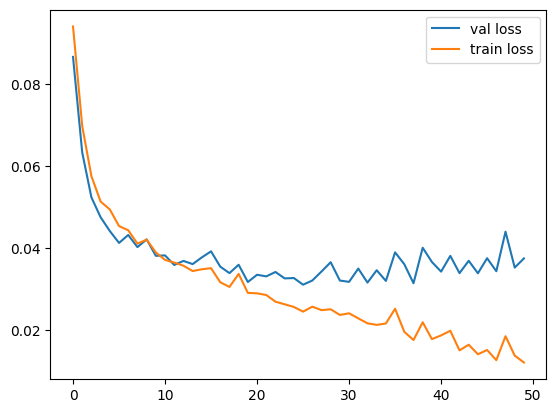

In [80]:
X_train, X_test, y_train, y_test = train_test_split(x_model_dropped, y_encoded, test_size=0.1, random_state=42)

new_model = deepcopy(classification_model)
new_model = train_model(new_model, 
                               torch.from_numpy(X_train), 
                               y_train, 
                               torch.from_numpy(X_test), 
                               y_test,
                               optim.Adam(new_model.parameters(), lr=0.001),
                               nn.CrossEntropyLoss())

This large difference between the validation and training loss implies the model is overfitting 

In [81]:
get_evaluations("Test set", y_true, y_pred)

Test set accuracy: 98.8%
Test set precision: 80.1%
Test set f1: 80.8%
Test set recall: 81.6%


{'accuracy': 0.9884708737864077,
 'precision': 0.8013180547938986,
 'f1': 0.8082455641863512,
 'recall': 0.8162374778159149}

In [ ]:
predictions_nn = new_model(torch.Tensor(X_test))
y_pred = np.array(torch.argmax(predictions_nn, dim=1))
y_true = np.array(y_test.argmax(axis=1))

In [57]:
def get_evaluations(name_data_set, y_true, y_pred) -> dict:
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  print(f"{name_data_set} accuracy: {(accuracy*100):.1f}%")
  print(f"{name_data_set} precision: {(precision*100):.1f}%")
  print(f"{name_data_set} f1: {(f1*100):.1f}%")
  print(f"{name_data_set} recall: {(recall*100):.1f}%")
  return {
      "accuracy": accuracy,
      "precision": precision,
      "f1": f1,
      "recall": recall,
  }

In [58]:
ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, split="train[70%:]",download_mode="reuse_cache_if_exists")

Generating test split: 100%|██████████| 6336/6336 [00:05<00:00, 1116.83 examples/s]


In [59]:
observation_columns = [obs for obs in list(ds.features.keys()) if not obs == 'raw_counts']
obs_data = pd.DataFrame(ds.select_columns(observation_columns).data.to_pandas(),columns=observation_columns)
lil = lil_matrix((len(ds),ds[0]['size']))
lil.data = np.array(ds['raw_counts'],dtype="object")
lil.rows = np.array(ds['rows'],dtype="object")
adata_unseen = ad.AnnData(lil.tocsr(),obs=obs_data)
adata_unseen.var_names = ds.features['raw_counts'].id.split(",")
adata_unseen.var['gene_name'] = adata_unseen.var_names.str.upper()

In [ ]:
data_unseen = scgpt.process_data(adata_unseen, gene_names="gene_name")
x_unseen = scgpt.get_embeddings(data_unseen)
predictions_nn_unseen = new_model(torch.Tensor(x_unseen))

INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:
Embedding cells: 100%|██████████| 153/153 [08:28<00:00,  3.32s/it]


In [61]:
y_true_unseen = np.array(adata_unseen.obs["LVL1"].tolist())
y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen, dim=1))]

scgpt_results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

Evaluation set accuracy: 99.1%
Evaluation set precision: 72.2%
Evaluation set f1: 74.6%
Evaluation set recall: 78.7%


<Axes: >

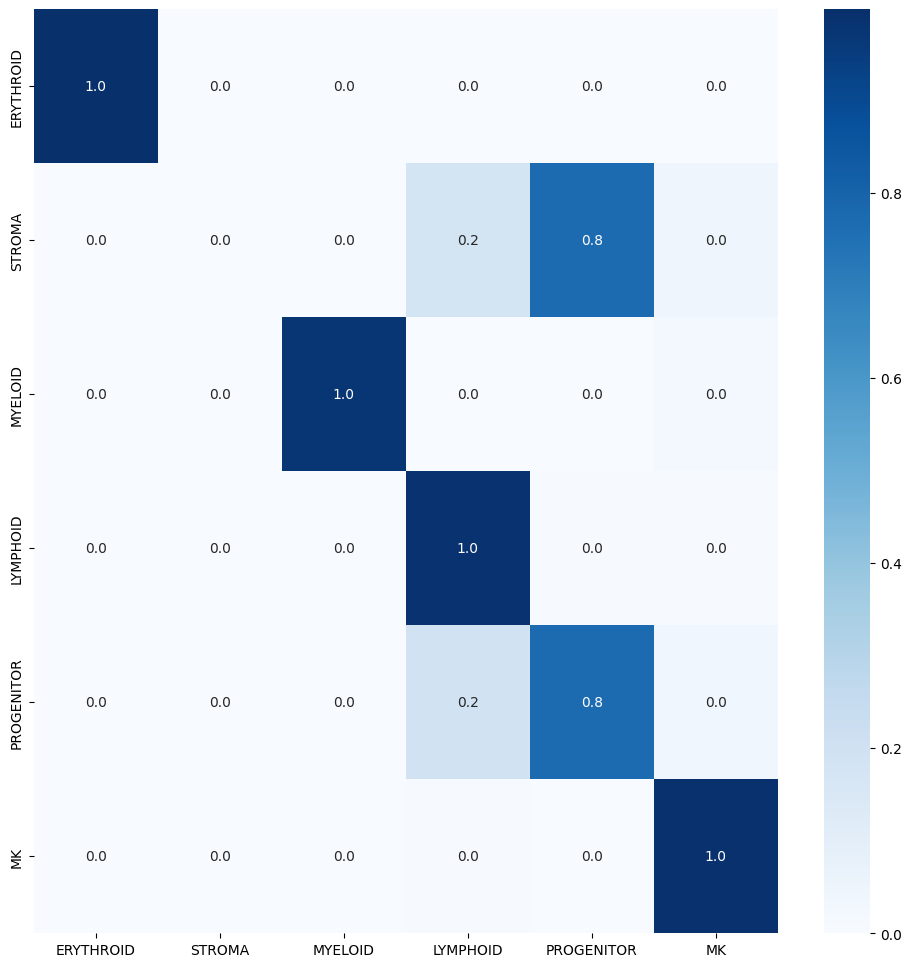

In [62]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

set_predicted_cell_types = list(adata_unseen.obs["LVL1"].unique())
for i in set(y_pred_unseen):
    if i not in set_predicted_cell_types:
        set_predicted_cell_types.remove(i)

cm = confusion_matrix(y_true_unseen, y_pred_unseen)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=set_predicted_cell_types[:cm.shape[0]], columns=set_predicted_cell_types[:cm.shape[1]])
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")

In [ ]:
num_types = adata.obs["LVL1"].unique().shape[0]
id2type = dict(enumerate(adata.obs["LVL1"].astype("category").cat.categories))
celltypes_labels = np.array(adata.obs["LVL1"].tolist())
labels = adata.obs["LVL1"].unique()
print(labels)
for i in range(6):
    #print(f"{labels[i]} has {len(adata[adata.obs["LVL1"]==labels[i]])} datapoints")
    print(labels[i],len(adata[adata.obs["LVL1"]==labels[i]]))

lymphoid_data = adata[adata.obs["LVL1"]==labels[5]]
# store frequency of genes in a list where index corresponds to gene_index shown in row
gene_list = np.zeros(len(adata.var))
for x in lymphoid_data.obs['rows']:
    for gene in x:
        gene_list[gene] += 1

print(np.where(gene_list==29.0)[0])
knockout = np.where(gene_list==29.0)[0]



['STROMA' 'ERYTHROID' 'MYELOID' 'MK' 'PROGENITOR' 'LYMPHOID']
STROMA 7824
ERYTHROID 3468
MYELOID 4888
MK 118
PROGENITOR 147
LYMPHOID 29
[ 5881  5883  9558  9788  9802  9902 10281 10975 11895 11968 12217 12525
 12538 13775 14048 14731 14739 14740 14742 14743 14824 14883 14994 15725
 16226 16227 16300 16379 16405 16720 16962 17219 17263 17264 17510 17653
 17682 17695 17858 17876 19349 22522 22524 22525 22526 22527 22531 22532
 22533 22723 22728 22829 23015 23037 23415 23682 23907 23995 24184 24328
 24484 24494 25142 25568 25613 25688 25941 25944 31320 31321 31323 31324
 31325 31326 31327 31328 31329 31331 31332 31333 31334 31335 31338 31340
 31341 31344 31346 31347 31348 31349 31350 31351 31352 31355 31356 31357
 31358 31361 31362 31363 31364 31367 31368 31369 31370 31371 31372 31374
 31375 31376 31377 31378 31398 31399 31400 31401 31402 31403 31404 31405
 31406 31407 31409 31411 31412 31413 31414 31415 31416 31417 31419 31421
 31422 31423 31426 31427 31441 31442 31443 31444 31968 32020 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
scgpt_config = scGPTConfig(batch_size=50, device=device)
scgpt = scGPT(configurer = scgpt_config)
#print(load_model(scgpt_config)[1])


def knockout_genes(data,model,genes):
  """ Generate embeddings for the original dataset and modified dataset using
  the selected model. The modified dataset has gene expressions set to 0 for
  all genes present in the genes list.

  Inputs:
      data (anndata): dataset that is being considered
      model ()
  """
  # knockout genes using batching to reduce explosion in RAM usage
  batch_size = 100
  original_data = data.copy()
  #print(len(genes))
  
  #gene_indices = [data.var.index.get_loc(gene) for gene in genes if gene in data.var.index]
  # update data in a vectorised way all at once to reduce memory spike
  data.X[:,genes] = 0 
  
  new_data = model.process_data(adata = data, gene_names="gene_name")
  print([i for i in knockout if data.var["gene_name"][i] not in new_data.vocab])
  
  
  x_model_dropped = model.get_embeddings(new_data)
  # generate embeddings on original data
  new_data1 = model.process_data(adata = original_data, gene_names = "gene_name")
  x_model = model.get_embeddings(new_data1)
  return x_model, x_model_dropped
#genes_to_knockout = ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M']
#genes_to_knockout = list(adata.var_names[0:40])

x_model, x_model_dropped = knockout_genes(adata,scgpt,knockout)



INFO:helical.utils.downloader:File: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/vocab.json' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/vocab.json'
INFO:helical.utils.downloader:File: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/best_model.pt' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/best_model.pt'
INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:


[17219, 17263, 17264]


Embedding cells: 100%|██████████| 330/330 [03:28<00:00,  1.59it/s]
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:
Embedding cells: 100%|██████████| 330/330 [09:02<00:00,  1.64s/it]


for unperturbed dataset:
Evaluation set accuracy: 99.1%
Evaluation set precision: 73.8%
Evaluation set f1: 75.5%
Evaluation set recall: 77.8%


for data with knockouts on lymphoid genes: Evaluation set accuracy: 99.1%
Evaluation set precision: 72.2%
Evaluation set f1: 74.6%
Evaluation set recall: 78.7%

All lymphoid cells correctly identified in each case
